In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## MASK DETECTION-MobileNet MODEL

In [22]:
#The data used to train this model can be found in the below link,
#https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset
#If the model is to be built locally, this dataset must be downloaded first

In [3]:
import matplotlib.pyplot as plt
import os
import time
import random
import cv2
#from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
#import seaborn as sns
import keras
from keras import layers
from keras.applications import MobileNetV2
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
import matplotlib.gridspec as gridspec

In [5]:
train_dir = "../input/face-mask-12k-images-dataset/Face Mask Dataset/Train"
val_dir = "../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation"
test_dir = "../input/face-mask-12k-images-dataset/Face Mask Dataset/Test"

train_dir = "Face Mask Dataset/Train"
val_dir = "Face Mask Dataset/Validation"
test_dir = "Face Mask Dataset/Test"

classes = ["With Mask", "Without Mask"]

### Data Loading and Preprocessing

In [6]:
## Data Augmentation
# Dataset Loader
train_datagen = ImageDataGenerator(
                                rescale=1./255,
                                rotation_range=0.2,
                                #width_shift_range=0.1,
                                #height_shift_range=0.1,
                                shear_range=0.2,
                                #zoom_range=0.09,
                                horizontal_flip=True,
                                vertical_flip=False,
                                #validation_split=0.1
                                )

val_datagen = ImageDataGenerator(rescale=1./255)

# Image Generator Config
target_size = (224, 224)
batch_size = 16

# Loading Train Dataset
train_dataset = train_datagen.flow_from_directory(train_dir,
                                                  target_size=target_size,
                                                  interpolation="nearest",
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=True)

# Loading Validation Dataset
val_dataset = val_datagen.flow_from_directory(val_dir,
                                              target_size=target_size,
                                              interpolation="nearest",
                                              batch_size=batch_size,
                                              class_mode="categorical",
                                              shuffle=False)

# Load Test Dataset
test_dataset = val_datagen.flow_from_directory(test_dir,
                                            target_size=target_size,
                                            interpolation="nearest",
                                            batch_size=1,
                                            class_mode=None,
                                            shuffle=False)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [7]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

625
50
992


In [8]:
print("Shape of Images:", train_dataset[0][0][0].shape)
print("Shape of Output labels:", train_dataset[0][1][0].shape)
print("Shape of Images:", val_dataset[0][0][0].shape)
print("Shape of Output labels:", val_dataset[0][1][0].shape)

Shape of Images: (224, 224, 3)
Shape of Output labels: (2,)
Shape of Images: (224, 224, 3)
Shape of Output labels: (2,)


### Model

In [9]:
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

9412608/9406464 [==============================] - 35s 4us/step


### Adding Extra Layers

In [10]:
# Freezing Layer
for layer in base_model.layers:
    layer.trainable = False

model = keras.Sequential()
model.add(base_model)
model.add(layers.Conv2D(128, 3, padding = "valid", strides = 2, activation = 'relu'))
#model.add(layers.AveragePooling2D(pool_size = (7, 7)))
model.add(layers.Flatten())
#model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(2, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 3, 3, 128)         1474688   
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               590336    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 4,388,930
Trainable params: 2,130,946
Non-trainable params: 2,257,984
______________________________________

### Training the Model

In [11]:
## Setting backprop of model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics ="accuracy")

In [12]:
start_time = time.time()
EPOCHS = 50
history = model.fit_generator(train_dataset,
                               steps_per_epoch=len(train_dataset)//train_dataset.batch_size,
                               validation_data=val_dataset, 
                               validation_steps=len(val_dataset)//val_dataset.batch_size,
                               epochs=EPOCHS, 
                               )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
39/39 [==============================] - 24s 626ms/step - loss: 0.5276 - accuracy: 0.9022 - val_loss: 0.0624 - val_accuracy: 0.9583
Epoch 2/50
39/39 [==============================] - 23s 593ms/step - loss: 0.0799 - accuracy: 0.9808 - val_loss: 0.0455 - val_accuracy: 0.9792
Epoch 3/50
39/39 [==============================] - 22s 575ms/step - loss: 0.0634 - accuracy: 0.9760 - val_loss: 0.0061 - val_accuracy: 1.0000
Epoch 4/50
39/39 [==============================] - 24s 626ms/step - loss: 0.0246 - accuracy: 0.9872 - val_loss: 1.4820e-05 - val_accuracy: 1.0000
Epoch 5/50
39/39 [==============================] - 24s 618ms/step - loss: 0.0778 - accuracy: 0.9856 - val_loss: 0.0078 - val_accuracy: 1.0000
Epoch 6/50
39/39 [==============================] - 24s 627ms/step - loss: 0.0311 - accuracy: 0.9840 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 7/50
39/39 [==============================] - 25s 637ms/

In [13]:
print("--- %s minutes ---" % ((time.time() - start_time)/60))

--- 20.07698125441869 minutes ---


### Evaluation of the Model

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

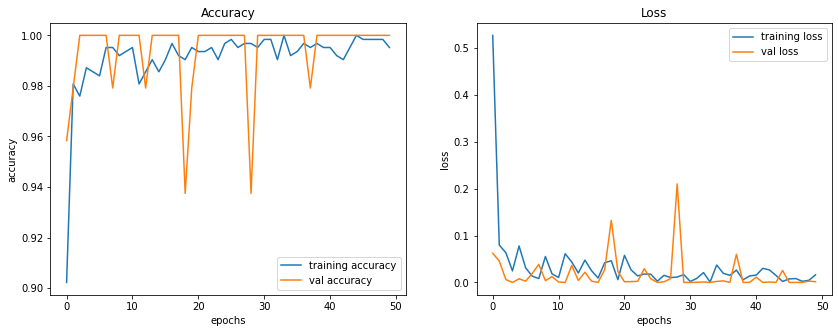

In [15]:
fig = plt.figure(figsize=(14,5))
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

### Testing the Model

In [16]:
probabilities = model.predict_generator(test_dataset)
y_pred = probabilities.argmax(axis=-1)
y_test = test_dataset.classes

Instructions for updating:
Please use Model.predict, which supports generators.


In [17]:
print("Accuracy Score of Model:", accuracy_score(y_pred,y_test) * 100)

Accuracy Score of Model: 98.89112903225806


In [21]:
labels = ["No Mask","Mask"]

In [19]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       483
           1       0.98      1.00      0.99       509

    accuracy                           0.99       992
   macro avg       0.99      0.99      0.99       992
weighted avg       0.99      0.99      0.99       992



In [20]:
model.save("models/final_mask_detection.h5")